In [1]:
# Libraries
import os
from importlib import reload
import keras
import numpy as np

# Scripts
from acml import data, runners, utils

## `main`

In [2]:
# Silence information messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 

GPU DETECTED ✓


### Load supervised training dataset

In [3]:
fold_dfs = data.get_fold_dfs_with_data(
    fold_definition_csv='data/deepship_5k_seg_3s.csv',
    new_path_to_root='data/csv_deepship_original_npz',
    npz=True,
    label_encodings={0:'Tanker', 1:'Cargo', 2:'Tug', 3:'Passengership'},
    n_folds=4
)
print('Successfully loaded folds with spectrograms.\n')

Successfully loaded folds with spectrograms.



In [ ]:
fold_dfs[0]['spectrogram'][0].shape

In [4]:
import cv2
for df in fold_dfs:
    df['spectrogram'] = df['spectrogram'].apply(lambda x: cv2.resize(x, (128, 128)))

In [5]:
fold_dfs[0]['spectrogram'][0].shape

(128, 128)

In [6]:
k_folds = data.get_splits_for_all_folds(
    fold_dfs, 
    conv_channel=True,
    verbose=False
)

### Import pretrained model and concatenate with supervised learning model

In [7]:
pretrained = keras.models.load_model('models\keras\irfan_pretrain.keras')
encoder_output = pretrained.get_layer(name='encoder_output').output
encoder = keras.Model(inputs=pretrained.input, outputs=encoder_output)

In [8]:
from models import cnn_lstm

cnn_lstm_model = cnn_lstm.get_cnn_lstm(
    input_shape=encoder_output.shape[1:],
    input_name='latent',
    num_classes=4,
    verbose=True
)

Model: "cnn_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent (InputLayer)         [(None, 16, 16, 64)]      0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          369

In [9]:
combined_input = keras.Input(shape=pretrained.input.shape[1:], name='spectrogram')
encoded_output = encoder(combined_input)
cnn_lstm_output = cnn_lstm_model(encoded_output)
combined_model = keras.Model(inputs=combined_input, outputs=cnn_lstm_output)

combined_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

combined_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spectrogram (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 model (Functional)          (None, 16, 16, 64)        75264     
                                                                 
 cnn_lstm (Functional)       (None, 4)                 5085636   
                                                                 
Total params: 5,160,900
Trainable params: 5,159,748
Non-trainable params: 1,152
_________________________________________________________________


### Configure model

In [10]:
# These are kwargs for Model.fit() and Model.evaluate() excluding x and y.
fit_kwargs = {
    'epochs': 20,
    'validation_split': 0.2,
    'batch_size': 32,
    'verbose': 1,
    'callbacks': [cnn_lstm.callback_early_stop()]
}

eval_kwargs = {
    'batch_size': 32,
    'verbose': 1
}

### Run k-fold cross val

In [11]:
model, histories, evals = runners.k_fold_cross_validation(
    k_folds=k_folds,
    model=combined_model,
    fit_xy=('X_train', 'y_train'),
    fit_kwargs=fit_kwargs,
    eval_xy=('X_test', 'y_test'),
    eval_kwargs=eval_kwargs,
    use_cpu=False
)

FOLD 1
Epoch 1/20
465/465 [==============================] - 34s 53ms/step - loss: 0.7067 - accuracy: 0.7081 - val_loss: 1.0277 - val_accuracy: 0.6130
Epoch 2/20
465/465 [==============================] - 21s 46ms/step - loss: 0.4451 - accuracy: 0.8259 - val_loss: 1.5440 - val_accuracy: 0.4770
Epoch 3/20
465/465 [==============================] - 23s 50ms/step - loss: 0.3042 - accuracy: 0.8852 - val_loss: 1.2839 - val_accuracy: 0.6027
Epoch 4/20
465/465 [==============================] - 23s 50ms/step - loss: 0.2366 - accuracy: 0.9131 - val_loss: 1.6832 - val_accuracy: 0.5411
Epoch 5/20
465/465 [==============================] - 24s 51ms/step - loss: 0.1946 - accuracy: 0.9286 - val_loss: 1.9943 - val_accuracy: 0.4727
Epoch 6/20
465/465 [==============================] - 23s 49ms/step - loss: 0.1524 - accuracy: 0.9447 - val_loss: 1.7656 - val_accuracy: 0.5650
Epoch 7/20
465/465 [==============================] - 22s 48ms/step - loss: 0.1387 - accuracy: 0.9506 - val_loss: 1.7540 - val_ac

### Calculate metrics

In [12]:
loss, acc = utils.calculate_metrics(evals)
print(f"Average loss: {loss}")
print(f"Average accuracy: {acc}")

Average loss: 1.2992751598358154
Average accuracy: 0.7471696436405182


C:\Users\sonar\AppData\Local\Temp\ipykernel_26844\201228151.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


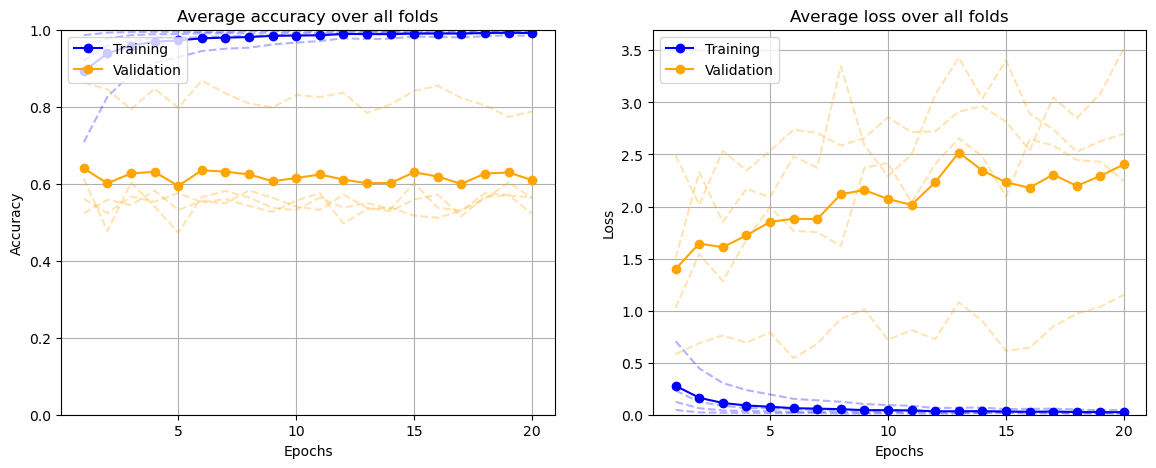

In [13]:
fig = utils.get_acc_loss_curves(histories, overlay=True)
fig.show()